# Baseline Results for Multiclass Classification (pain area in body)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.utils import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset

In [2]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)

cnn_auc = []
rnn_auc = []

In [3]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight,verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

In [4]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [5]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(380, 1, 350, 35) (380, 4)
(235, 1, 350, 35) (235, 4)


In [6]:
classes = get_class_names('skeleton', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       245
Back Region       73
Upper Body        57
Head and Neck      5
dtype: int64

In [7]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.3013698630136987, 1: 19.0, 2: 0.3877551020408163, 3: 1.6666666666666667}

### CNN + Bidirectional LSTM

Epoch 1/25
8/8 - 3s - loss: 48.4385 - accuracy: 0.2055 - auc: 0.4643 - precision: 0.2055 - recall: 0.2055 - f1_score: 0.1578 - val_loss: 46.7810 - val_accuracy: 0.1969 - val_auc: 0.4677 - val_precision: 0.1969 - val_recall: 0.1969 - val_f1_score: 0.0822 - 3s/epoch - 373ms/step
Epoch 2/25
8/8 - 0s - loss: 24.7439 - accuracy: 0.2372 - auc: 0.5065 - precision: 0.2341 - recall: 0.2332 - f1_score: 0.1880 - val_loss: 40.3013 - val_accuracy: 0.0866 - val_auc: 0.3911 - val_precision: 0.0866 - val_recall: 0.0866 - val_f1_score: 0.0399 - 356ms/epoch - 44ms/step
Epoch 3/25
8/8 - 0s - loss: 32.3675 - accuracy: 0.2806 - auc: 0.5188 - precision: 0.2806 - recall: 0.2806 - f1_score: 0.2054 - val_loss: 34.4024 - val_accuracy: 0.1969 - val_auc: 0.4646 - val_precision: 0.1969 - val_recall: 0.1969 - val_f1_score: 0.0822 - 345ms/epoch - 43ms/step
Epoch 4/25
8/8 - 0s - loss: 14.5940 - accuracy: 0.3715 - auc: 0.6003 - precision: 0.3730 - recall: 0.3715 - f1_score: 0.3118 - val_loss: 11.1497 - val_accuracy: 0

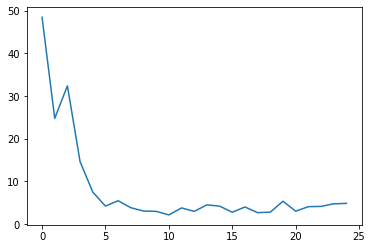

Epoch 1/25
8/8 - 3s - loss: 47.4911 - accuracy: 0.2292 - auc_1: 0.4787 - precision_1: 0.2292 - recall_1: 0.2292 - f1_score: 0.1761 - val_loss: 26.1102 - val_accuracy: 0.1890 - val_auc_1: 0.4593 - val_precision_1: 0.1890 - val_recall_1: 0.1890 - val_f1_score: 0.0795 - 3s/epoch - 340ms/step
Epoch 2/25
8/8 - 0s - loss: 27.1133 - accuracy: 0.2095 - auc_1: 0.4906 - precision_1: 0.2112 - recall_1: 0.2095 - f1_score: 0.1483 - val_loss: 13.0537 - val_accuracy: 0.6299 - val_auc_1: 0.7527 - val_precision_1: 0.6299 - val_recall_1: 0.6299 - val_f1_score: 0.1942 - 372ms/epoch - 46ms/step
Epoch 3/25
8/8 - 0s - loss: 21.9452 - accuracy: 0.3676 - auc_1: 0.5821 - precision_1: 0.3676 - recall_1: 0.3676 - f1_score: 0.2113 - val_loss: 33.9903 - val_accuracy: 0.0315 - val_auc_1: 0.3470 - val_precision_1: 0.0315 - val_recall_1: 0.0315 - val_f1_score: 0.0466 - 369ms/epoch - 46ms/step
Epoch 4/25
8/8 - 0s - loss: 15.8739 - accuracy: 0.0988 - auc_1: 0.3630 - precision_1: 0.0988 - recall_1: 0.0988 - f1_score: 0.

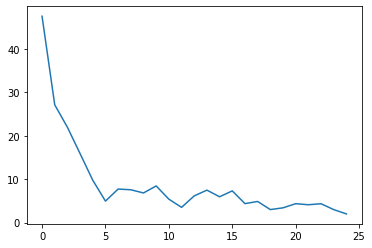

Epoch 1/25
8/8 - 3s - loss: 89.5261 - accuracy: 0.3622 - auc_2: 0.5964 - precision_2: 0.3622 - recall_2: 0.3622 - f1_score: 0.2157 - val_loss: 31.3407 - val_accuracy: 0.1508 - val_auc_2: 0.4045 - val_precision_2: 0.1508 - val_recall_2: 0.1508 - val_f1_score: 0.0816 - 3s/epoch - 344ms/step
Epoch 2/25
8/8 - 0s - loss: 27.9873 - accuracy: 0.3504 - auc_2: 0.5832 - precision_2: 0.3504 - recall_2: 0.3504 - f1_score: 0.2479 - val_loss: 33.1436 - val_accuracy: 0.1190 - val_auc_2: 0.3776 - val_precision_2: 0.1190 - val_recall_2: 0.1190 - val_f1_score: 0.0827 - 378ms/epoch - 47ms/step
Epoch 3/25
8/8 - 0s - loss: 15.7384 - accuracy: 0.0669 - auc_2: 0.3443 - precision_2: 0.0669 - recall_2: 0.0669 - f1_score: 0.0761 - val_loss: 16.8420 - val_accuracy: 0.1190 - val_auc_2: 0.3646 - val_precision_2: 0.1190 - val_recall_2: 0.1190 - val_f1_score: 0.0969 - 419ms/epoch - 52ms/step
Epoch 4/25
8/8 - 0s - loss: 8.8953 - accuracy: 0.1299 - auc_2: 0.3494 - precision_2: 0.1331 - recall_2: 0.1299 - f1_score: 0.1

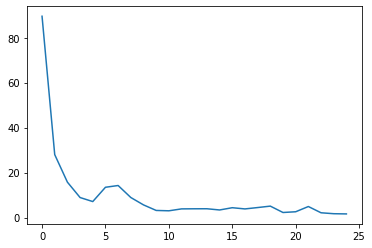

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = cnnlstm_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 22.55% 
Balanced Accuracy: 22.15% 
ROC/AUC: 0.56 
Precision: 0.21 
Recall: 0.15 
F1 score: 0.18


### RCNN

Epoch 1/25
8/8 - 2s - loss: 2.2892 - accuracy: 0.3004 - auc_3: 0.6179 - precision_3: 0.2468 - recall_3: 0.1542 - f1_score: 0.2195 - val_loss: 35.3962 - val_accuracy: 0.0866 - val_auc_3: 0.3911 - val_precision_3: 0.0866 - val_recall_3: 0.0866 - val_f1_score: 0.0399 - 2s/epoch - 220ms/step
Epoch 2/25
8/8 - 0s - loss: 1.0591 - accuracy: 0.3794 - auc_3: 0.6833 - precision_3: 0.3727 - recall_3: 0.1621 - f1_score: 0.3034 - val_loss: 3.0550 - val_accuracy: 0.6299 - val_auc_3: 0.7699 - val_precision_3: 0.6349 - val_recall_3: 0.6299 - val_f1_score: 0.1980 - 205ms/epoch - 26ms/step
Epoch 3/25
8/8 - 0s - loss: 0.9427 - accuracy: 0.3953 - auc_3: 0.7205 - precision_3: 0.4266 - recall_3: 0.2411 - f1_score: 0.3442 - val_loss: 14.2786 - val_accuracy: 0.0866 - val_auc_3: 0.3911 - val_precision_3: 0.0866 - val_recall_3: 0.0866 - val_f1_score: 0.0399 - 205ms/epoch - 26ms/step
Epoch 4/25
8/8 - 0s - loss: 0.8678 - accuracy: 0.4783 - auc_3: 0.7873 - precision_3: 0.5068 - recall_3: 0.2964 - f1_score: 0.4052 

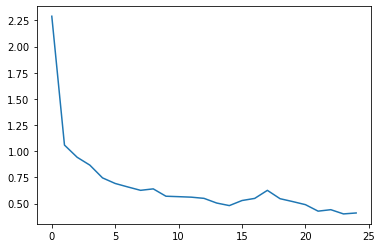

Epoch 1/25
8/8 - 1s - loss: 2.6232 - accuracy: 0.3083 - auc_4: 0.5855 - precision_4: 0.3226 - recall_4: 0.1976 - f1_score: 0.2251 - val_loss: 12.0990 - val_accuracy: 0.1811 - val_auc_4: 0.4290 - val_precision_4: 0.1811 - val_recall_4: 0.1811 - val_f1_score: 0.1122 - 1s/epoch - 176ms/step
Epoch 2/25
8/8 - 0s - loss: 1.2668 - accuracy: 0.2925 - auc_4: 0.6098 - precision_4: 0.2680 - recall_4: 0.1621 - f1_score: 0.2411 - val_loss: 5.4843 - val_accuracy: 0.4173 - val_auc_4: 0.6707 - val_precision_4: 0.4206 - val_recall_4: 0.4173 - val_f1_score: 0.2301 - 208ms/epoch - 26ms/step
Epoch 3/25
8/8 - 0s - loss: 1.0600 - accuracy: 0.3597 - auc_4: 0.6762 - precision_4: 0.3359 - recall_4: 0.1739 - f1_score: 0.3043 - val_loss: 4.8997 - val_accuracy: 0.1811 - val_auc_4: 0.4721 - val_precision_4: 0.1825 - val_recall_4: 0.1811 - val_f1_score: 0.1221 - 208ms/epoch - 26ms/step
Epoch 4/25
8/8 - 0s - loss: 0.9327 - accuracy: 0.4822 - auc_4: 0.7803 - precision_4: 0.5081 - recall_4: 0.2490 - f1_score: 0.3843 -

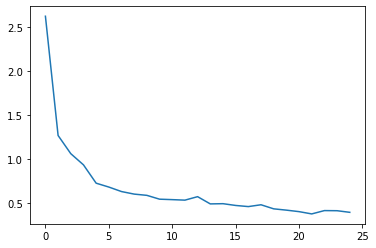

Epoch 1/25
8/8 - 1s - loss: 2.5998 - accuracy: 0.3819 - auc_5: 0.6501 - precision_5: 0.4195 - recall_5: 0.2874 - f1_score: 0.2670 - val_loss: 63.2031 - val_accuracy: 0.0000e+00 - val_auc_5: 0.3333 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0000e+00 - 1s/epoch - 178ms/step
Epoch 2/25
8/8 - 0s - loss: 1.7786 - accuracy: 0.1378 - auc_5: 0.3593 - precision_5: 0.1154 - recall_5: 0.0827 - f1_score: 0.1566 - val_loss: 6.9455 - val_accuracy: 0.1746 - val_auc_5: 0.4131 - val_precision_5: 0.1746 - val_recall_5: 0.1746 - val_f1_score: 0.0988 - 209ms/epoch - 26ms/step
Epoch 3/25
8/8 - 0s - loss: 1.0386 - accuracy: 0.4764 - auc_5: 0.7469 - precision_5: 0.5256 - recall_5: 0.3228 - f1_score: 0.3785 - val_loss: 4.8867 - val_accuracy: 0.6111 - val_auc_5: 0.7603 - val_precision_5: 0.6111 - val_recall_5: 0.6111 - val_f1_score: 0.2083 - 218ms/epoch - 27ms/step
Epoch 4/25
8/8 - 0s - loss: 0.8905 - accuracy: 0.5157 - auc_5: 0.8123 - precision_5: 0.5210 - recall_5: 0.3425 - f1

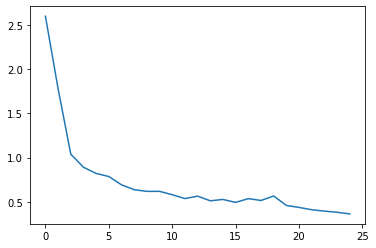

In [10]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [11]:
y_pred = rcnn_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_body_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 22.39% 
ROC/AUC: 0.69 
Precision: 0.39 
Recall: 0.33 
F1 score: 0.22


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [12]:
X_train, X_test, y_train, y_test = load_dataset('AUs', nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 25) (366, 4)
(231, 1, 350, 25) (231, 4)


In [13]:
classes = get_class_names('AUs', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       236
Back Region       69
Upper Body        57
Head and Neck      4
dtype: int64

In [14]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.326086956521739, 1: 22.875, 2: 0.3877118644067797, 3: 1.605263157894737}

### CNN + Bidirectional LSTM

Epoch 1/25
8/8 - 3s - loss: 88768.1875 - accuracy: 0.2910 - auc_6: 0.5250 - precision_6: 0.2910 - recall_6: 0.2910 - f1_score: 0.1631 - val_loss: 80067.6016 - val_accuracy: 0.1066 - val_auc_6: 0.3988 - val_precision_6: 0.1066 - val_recall_6: 0.1066 - val_f1_score: 0.0565 - 3s/epoch - 377ms/step
Epoch 2/25
8/8 - 0s - loss: 63740.8438 - accuracy: 0.1230 - auc_6: 0.4153 - precision_6: 0.1230 - recall_6: 0.1230 - f1_score: 0.0652 - val_loss: 76716.2969 - val_accuracy: 0.1311 - val_auc_6: 0.4208 - val_precision_6: 0.1311 - val_recall_6: 0.1311 - val_f1_score: 0.0580 - 364ms/epoch - 45ms/step
Epoch 3/25
8/8 - 0s - loss: 60781.2734 - accuracy: 0.1680 - auc_6: 0.4454 - precision_6: 0.1680 - recall_6: 0.1680 - f1_score: 0.0719 - val_loss: 78715.7734 - val_accuracy: 0.1311 - val_auc_6: 0.4208 - val_precision_6: 0.1311 - val_recall_6: 0.1311 - val_f1_score: 0.0580 - 361ms/epoch - 45ms/step
Epoch 4/25
8/8 - 0s - loss: 41877.3398 - accuracy: 0.1680 - auc_6: 0.4493 - precision_6: 0.1680 - recall_6: 

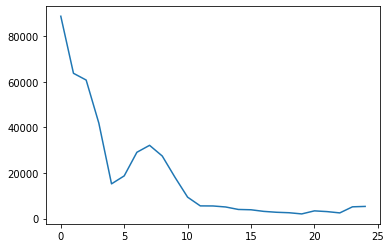

Epoch 1/25
8/8 - 3s - loss: 88954.0156 - accuracy: 0.1885 - auc_7: 0.4599 - precision_7: 0.1885 - recall_7: 0.1885 - f1_score: 0.1492 - val_loss: 49657.6719 - val_accuracy: 0.1967 - val_auc_7: 0.4678 - val_precision_7: 0.1967 - val_recall_7: 0.1967 - val_f1_score: 0.1120 - 3s/epoch - 343ms/step
Epoch 2/25
8/8 - 0s - loss: 38053.2812 - accuracy: 0.2951 - auc_7: 0.5291 - precision_7: 0.2975 - recall_7: 0.2951 - f1_score: 0.1716 - val_loss: 40133.7578 - val_accuracy: 0.4918 - val_auc_7: 0.6685 - val_precision_7: 0.4918 - val_recall_7: 0.4918 - val_f1_score: 0.2352 - 372ms/epoch - 46ms/step
Epoch 3/25
8/8 - 0s - loss: 42154.2305 - accuracy: 0.3484 - auc_7: 0.5684 - precision_7: 0.3484 - recall_7: 0.3484 - f1_score: 0.2210 - val_loss: 29501.3203 - val_accuracy: 0.5574 - val_auc_7: 0.7250 - val_precision_7: 0.5574 - val_recall_7: 0.5574 - val_f1_score: 0.2484 - 389ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 38531.7812 - accuracy: 0.2172 - auc_7: 0.4732 - precision_7: 0.2172 - recall_7: 

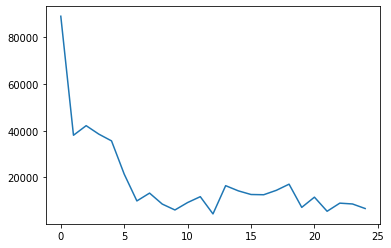

Epoch 1/25
8/8 - 3s - loss: 62124.2812 - accuracy: 0.2090 - auc_8: 0.4757 - precision_8: 0.2090 - recall_8: 0.2090 - f1_score: 0.1511 - val_loss: 16346.3662 - val_accuracy: 0.2213 - val_auc_8: 0.4809 - val_precision_8: 0.2213 - val_recall_8: 0.2213 - val_f1_score: 0.0906 - 3s/epoch - 344ms/step
Epoch 2/25
8/8 - 0s - loss: 15947.2461 - accuracy: 0.1270 - auc_8: 0.4180 - precision_8: 0.1270 - recall_8: 0.1270 - f1_score: 0.0654 - val_loss: 26473.8887 - val_accuracy: 0.2213 - val_auc_8: 0.4809 - val_precision_8: 0.2213 - val_recall_8: 0.2213 - val_f1_score: 0.0906 - 369ms/epoch - 46ms/step
Epoch 3/25
8/8 - 0s - loss: 12401.5830 - accuracy: 0.1270 - auc_8: 0.4180 - precision_8: 0.1270 - recall_8: 0.1270 - f1_score: 0.0733 - val_loss: 28029.0293 - val_accuracy: 0.2049 - val_auc_8: 0.4699 - val_precision_8: 0.2049 - val_recall_8: 0.2049 - val_f1_score: 0.0862 - 374ms/epoch - 47ms/step
Epoch 4/25
8/8 - 0s - loss: 11523.2939 - accuracy: 0.1270 - auc_8: 0.4180 - precision_8: 0.1270 - recall_8: 

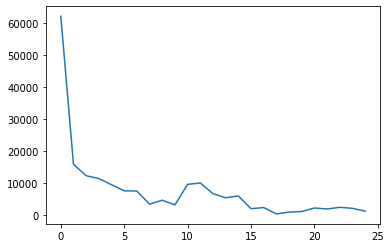

In [15]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [16]:
y_pred = cnnlstm_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 17.32% 
Balanced Accuracy: 24.58% 
ROC/AUC: 0.59 
Precision: 0.17 
Recall: 0.01 
F1 score: 0.08


### RCNN

Epoch 1/25
8/8 - 2s - loss: 3.3911 - accuracy: 0.3689 - auc_9: 0.6023 - precision_9: 0.1978 - recall_9: 0.0738 - f1_score: 0.2340 - val_loss: 2.3394 - val_accuracy: 0.0410 - val_auc_9: 0.5425 - val_precision_9: 0.5000 - val_recall_9: 0.0328 - val_f1_score: 0.0656 - 2s/epoch - 221ms/step
Epoch 2/25
8/8 - 0s - loss: 2.0807 - accuracy: 0.0779 - auc_9: 0.4383 - precision_9: 0.1273 - recall_9: 0.0574 - f1_score: 0.0797 - val_loss: 1.9470 - val_accuracy: 0.0328 - val_auc_9: 0.3577 - val_precision_9: 0.3750 - val_recall_9: 0.0246 - val_f1_score: 0.0205 - 195ms/epoch - 24ms/step
Epoch 3/25
8/8 - 0s - loss: 1.8301 - accuracy: 0.1066 - auc_9: 0.4432 - precision_9: 0.3729 - recall_9: 0.0902 - f1_score: 0.1118 - val_loss: 1.5494 - val_accuracy: 0.0246 - val_auc_9: 0.4457 - val_precision_9: 0.2500 - val_recall_9: 0.0164 - val_f1_score: 0.0543 - 193ms/epoch - 24ms/step
Epoch 4/25
8/8 - 0s - loss: 1.7619 - accuracy: 0.2664 - auc_9: 0.5615 - precision_9: 0.2667 - recall_9: 0.0656 - f1_score: 0.1921 - 

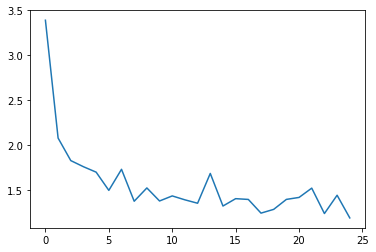

Epoch 1/25
8/8 - 1s - loss: 2.2450 - accuracy: 0.2254 - auc_10: 0.5507 - precision_10: 0.1569 - recall_10: 0.0328 - f1_score: 0.1636 - val_loss: 1.6203 - val_accuracy: 0.1148 - val_auc_10: 0.6154 - val_precision_10: 0.2500 - val_recall_10: 0.0082 - val_f1_score: 0.0522 - 1s/epoch - 175ms/step
Epoch 2/25
8/8 - 0s - loss: 1.6355 - accuracy: 0.1230 - auc_10: 0.5198 - precision_10: 0.5385 - recall_10: 0.0287 - f1_score: 0.0739 - val_loss: 2.2925 - val_accuracy: 0.0164 - val_auc_10: 0.4754 - val_precision_10: 0.2500 - val_recall_10: 0.0082 - val_f1_score: 0.0355 - 235ms/epoch - 29ms/step
Epoch 3/25
8/8 - 0s - loss: 1.5912 - accuracy: 0.0369 - auc_10: 0.4994 - precision_10: 0.0588 - recall_10: 0.0205 - f1_score: 0.0541 - val_loss: 2.1710 - val_accuracy: 0.0164 - val_auc_10: 0.4907 - val_precision_10: 0.2500 - val_recall_10: 0.0082 - val_f1_score: 0.0320 - 197ms/epoch - 25ms/step
Epoch 4/25
8/8 - 0s - loss: 1.6073 - accuracy: 0.2664 - auc_10: 0.6001 - precision_10: 0.3571 - recall_10: 0.0820 

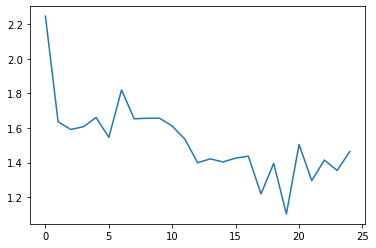

Epoch 1/25
8/8 - 1s - loss: 1.8195 - accuracy: 0.0533 - auc_11: 0.4367 - precision_11: 0.1636 - recall_11: 0.0369 - f1_score: 0.0719 - val_loss: 2.6518 - val_accuracy: 0.1967 - val_auc_11: 0.4275 - val_precision_11: 0.8000 - val_recall_11: 0.0328 - val_f1_score: 0.1350 - 1s/epoch - 174ms/step
Epoch 2/25
8/8 - 0s - loss: 1.5751 - accuracy: 0.2131 - auc_11: 0.5987 - precision_11: 0.2045 - recall_11: 0.0369 - f1_score: 0.1409 - val_loss: 1.6557 - val_accuracy: 0.6230 - val_auc_11: 0.7953 - val_precision_11: 0.8000 - val_recall_11: 0.0328 - val_f1_score: 0.2530 - 195ms/epoch - 24ms/step
Epoch 3/25
8/8 - 0s - loss: 1.2926 - accuracy: 0.6393 - auc_11: 0.7816 - precision_11: 0.5217 - recall_11: 0.0984 - f1_score: 0.2971 - val_loss: 1.3527 - val_accuracy: 0.6230 - val_auc_11: 0.8130 - val_precision_11: 0.8000 - val_recall_11: 0.0328 - val_f1_score: 0.2530 - 196ms/epoch - 24ms/step
Epoch 4/25
8/8 - 0s - loss: 1.2663 - accuracy: 0.6598 - auc_11: 0.8059 - precision_11: 0.6562 - recall_11: 0.0861 

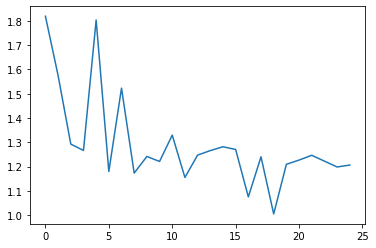

In [17]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [18]:
y_pred = rcnn_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 17.32% 
Balanced Accuracy: 24.58% 
ROC/AUC: 0.57 
Precision: 0.33 
Recall: 0.01 
F1 score: 0.08


## 3. Multimodal Early Fusion

### Dataset

In [19]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 60) (366, 4)
(231, 1, 350, 60) (231, 4)


### CNN + Bidirectional LSTM

Epoch 1/25
8/8 - 3s - loss: 39343.3594 - accuracy: 0.2582 - auc_12: 0.4979 - precision_12: 0.2582 - recall_12: 0.2582 - f1_score: 0.1997 - val_loss: 9282.6963 - val_accuracy: 0.5082 - val_auc_12: 0.6707 - val_precision_12: 0.5082 - val_recall_12: 0.5082 - val_f1_score: 0.2936 - 3s/epoch - 347ms/step
Epoch 2/25
8/8 - 0s - loss: 16141.3174 - accuracy: 0.2418 - auc_12: 0.4963 - precision_12: 0.2418 - recall_12: 0.2418 - f1_score: 0.1796 - val_loss: 20794.0820 - val_accuracy: 0.1393 - val_auc_12: 0.4090 - val_precision_12: 0.1393 - val_recall_12: 0.1393 - val_f1_score: 0.1461 - 426ms/epoch - 53ms/step
Epoch 3/25
8/8 - 0s - loss: 16626.9980 - accuracy: 0.1926 - auc_12: 0.4528 - precision_12: 0.1926 - recall_12: 0.1926 - f1_score: 0.1481 - val_loss: 25730.2383 - val_accuracy: 0.2131 - val_auc_12: 0.4803 - val_precision_12: 0.2131 - val_recall_12: 0.2131 - val_f1_score: 0.1333 - 386ms/epoch - 48ms/step
Epoch 4/25
8/8 - 0s - loss: 26945.8184 - accuracy: 0.2705 - auc_12: 0.5257 - precision_12: 

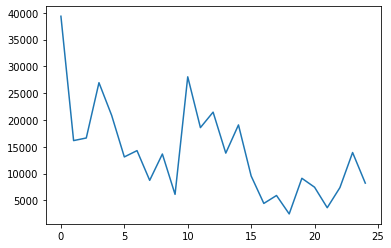

Epoch 1/25
8/8 - 3s - loss: 20873.7637 - accuracy: 0.1926 - auc_13: 0.4582 - precision_13: 0.1926 - recall_13: 0.1926 - f1_score: 0.1823 - val_loss: 5881.9951 - val_accuracy: 0.4836 - val_auc_13: 0.6568 - val_precision_13: 0.4836 - val_recall_13: 0.4836 - val_f1_score: 0.1844 - 3s/epoch - 346ms/step
Epoch 2/25
8/8 - 0s - loss: 12913.5781 - accuracy: 0.2049 - auc_13: 0.4727 - precision_13: 0.2049 - recall_13: 0.2049 - f1_score: 0.1428 - val_loss: 26904.7344 - val_accuracy: 0.1557 - val_auc_13: 0.4458 - val_precision_13: 0.1557 - val_recall_13: 0.1557 - val_f1_score: 0.1195 - 423ms/epoch - 53ms/step
Epoch 3/25
8/8 - 0s - loss: 7302.2852 - accuracy: 0.1762 - auc_13: 0.4408 - precision_13: 0.1762 - recall_13: 0.1762 - f1_score: 0.1276 - val_loss: 22417.6855 - val_accuracy: 0.2049 - val_auc_13: 0.4580 - val_precision_13: 0.2049 - val_recall_13: 0.2049 - val_f1_score: 0.1537 - 383ms/epoch - 48ms/step
Epoch 4/25
8/8 - 0s - loss: 9382.6416 - accuracy: 0.1598 - auc_13: 0.4281 - precision_13: 0.

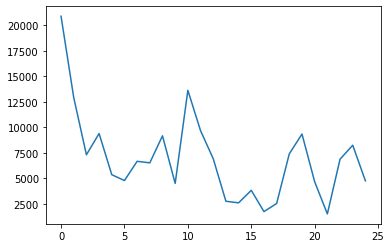

Epoch 1/25
8/8 - 3s - loss: 43638.1758 - accuracy: 0.2746 - auc_14: 0.5214 - precision_14: 0.2746 - recall_14: 0.2746 - f1_score: 0.1935 - val_loss: 52700.2305 - val_accuracy: 0.2213 - val_auc_14: 0.4809 - val_precision_14: 0.2213 - val_recall_14: 0.2213 - val_f1_score: 0.0906 - 3s/epoch - 348ms/step
Epoch 2/25
8/8 - 0s - loss: 4920.8784 - accuracy: 0.3770 - auc_14: 0.5932 - precision_14: 0.3770 - recall_14: 0.3770 - f1_score: 0.2015 - val_loss: 77107.3047 - val_accuracy: 0.6230 - val_auc_14: 0.7486 - val_precision_14: 0.6230 - val_recall_14: 0.6230 - val_f1_score: 0.2530 - 401ms/epoch - 50ms/step
Epoch 3/25
8/8 - 0s - loss: 2965.2405 - accuracy: 0.5492 - auc_14: 0.7075 - precision_14: 0.5492 - recall_14: 0.5492 - f1_score: 0.2523 - val_loss: 91597.0469 - val_accuracy: 0.2295 - val_auc_14: 0.4923 - val_precision_14: 0.2295 - val_recall_14: 0.2295 - val_f1_score: 0.1028 - 388ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 11741.5371 - accuracy: 0.1311 - auc_14: 0.4203 - precision_14: 0

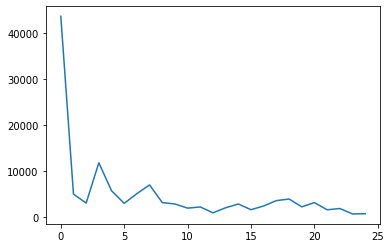

In [20]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [21]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 3.90% 
Balanced Accuracy: 26.82% 
ROC/AUC: 0.52 
Precision: 0.35 
Recall: 0.03 
F1 score: 0.04


### RCNN

Epoch 1/25
8/8 - 1s - loss: 1.8892 - accuracy: 0.1680 - auc_15: 0.4274 - precision_15: 0.1489 - recall_15: 0.0574 - f1_score: 0.1559 - val_loss: 2.9314 - val_accuracy: 0.1803 - val_auc_15: 0.4922 - val_precision_15: 0.5000 - val_recall_15: 0.0328 - val_f1_score: 0.1380 - 1s/epoch - 181ms/step
Epoch 2/25
8/8 - 0s - loss: 1.9391 - accuracy: 0.2254 - auc_15: 0.5426 - precision_15: 0.1923 - recall_15: 0.0615 - f1_score: 0.2489 - val_loss: 1.6772 - val_accuracy: 0.7049 - val_auc_15: 0.8307 - val_precision_15: 0.5000 - val_recall_15: 0.0328 - val_f1_score: 0.2555 - 228ms/epoch - 29ms/step
Epoch 3/25
8/8 - 0s - loss: 2.2423 - accuracy: 0.2582 - auc_15: 0.5930 - precision_15: 0.4085 - recall_15: 0.1189 - f1_score: 0.1842 - val_loss: 1.9301 - val_accuracy: 0.0410 - val_auc_15: 0.2068 - val_precision_15: 0.5000 - val_recall_15: 0.0328 - val_f1_score: 0.0633 - 231ms/epoch - 29ms/step
Epoch 4/25
8/8 - 0s - loss: 1.6145 - accuracy: 0.2254 - auc_15: 0.4573 - precision_15: 0.4833 - recall_15: 0.1189 

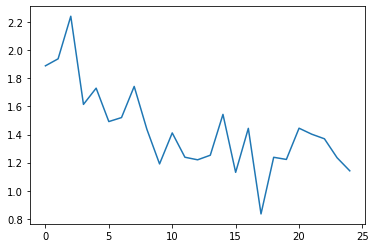

Epoch 1/25
8/8 - 2s - loss: 2.2716 - accuracy: 0.1270 - auc_16: 0.4797 - precision_16: 0.2025 - recall_16: 0.0656 - f1_score: 0.1191 - val_loss: 2.2831 - val_accuracy: 0.0164 - val_auc_16: 0.5027 - val_precision_16: 0.2500 - val_recall_16: 0.0082 - val_f1_score: 0.0320 - 2s/epoch - 244ms/step
Epoch 2/25
8/8 - 0s - loss: 1.8527 - accuracy: 0.1189 - auc_16: 0.5346 - precision_16: 0.2020 - recall_16: 0.0820 - f1_score: 0.1455 - val_loss: 1.7306 - val_accuracy: 0.0328 - val_auc_16: 0.4899 - val_precision_16: 0.7500 - val_recall_16: 0.0246 - val_f1_score: 0.0478 - 221ms/epoch - 28ms/step
Epoch 3/25
8/8 - 0s - loss: 1.5117 - accuracy: 0.1066 - auc_16: 0.5717 - precision_16: 0.7692 - recall_16: 0.0410 - f1_score: 0.0898 - val_loss: 1.6457 - val_accuracy: 0.1148 - val_auc_16: 0.5478 - val_precision_16: 0.2500 - val_recall_16: 0.0082 - val_f1_score: 0.0515 - 220ms/epoch - 28ms/step
Epoch 4/25
8/8 - 0s - loss: 1.2829 - accuracy: 0.1680 - auc_16: 0.5781 - precision_16: 0.4500 - recall_16: 0.1107 

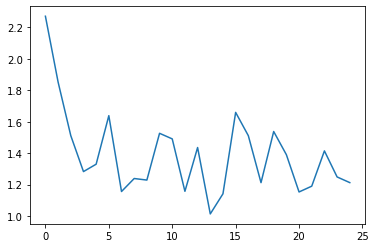

Epoch 1/25
8/8 - 1s - loss: 2.2378 - accuracy: 0.2705 - auc_17: 0.6214 - precision_17: 0.3514 - recall_17: 0.0533 - f1_score: 0.1818 - val_loss: 1.5975 - val_accuracy: 0.1967 - val_auc_17: 0.6028 - val_precision_17: 0.8000 - val_recall_17: 0.0328 - val_f1_score: 0.1350 - 1s/epoch - 181ms/step
Epoch 2/25
8/8 - 0s - loss: 1.8630 - accuracy: 0.4098 - auc_17: 0.6505 - precision_17: 0.3205 - recall_17: 0.1025 - f1_score: 0.2408 - val_loss: 2.0773 - val_accuracy: 0.6230 - val_auc_17: 0.7538 - val_precision_17: 0.8000 - val_recall_17: 0.0328 - val_f1_score: 0.2530 - 234ms/epoch - 29ms/step
Epoch 3/25
8/8 - 0s - loss: 1.7684 - accuracy: 0.3279 - auc_17: 0.6311 - precision_17: 0.2619 - recall_17: 0.0451 - f1_score: 0.2243 - val_loss: 1.5883 - val_accuracy: 0.1967 - val_auc_17: 0.6607 - val_precision_17: 0.8000 - val_recall_17: 0.0328 - val_f1_score: 0.1350 - 236ms/epoch - 30ms/step
Epoch 4/25
8/8 - 0s - loss: 1.8706 - accuracy: 0.2459 - auc_17: 0.5562 - precision_17: 0.3372 - recall_17: 0.1189 

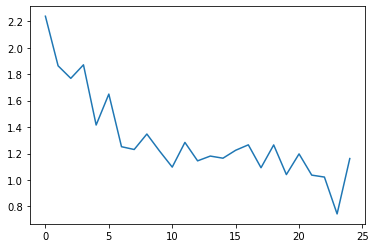

In [22]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [23]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 17.32% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.62 
Precision: 0.33 
Recall: 0.01 
F1 score: 0.07


## 4. Multimodal Late Fusion

### Dataset

In [24]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, nopain=False)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 1, 350, 35) (366, 4)
(231, 1, 350, 35) (231, 4)


In [25]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', nopain=False)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 1, 350, 25) (366, 4)
(231, 1, 350, 25) (231, 4)


In [26]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### CNN + Bidirectional LSTM

In [27]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(64)(flatten_1)
        dense_1 = Dense(64, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(64)(flatten_2)
        dense_2 = Dense(64, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
8/8 - 4s - loss: 1.5092 - accuracy: 0.1967 - auc_18: 0.5342 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0828 - val_loss: 1.3333 - val_accuracy: 0.1557 - val_auc_18: 0.5990 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0718 - 4s/epoch - 466ms/step
Epoch 2/25
8/8 - 0s - loss: 1.5012 - accuracy: 0.2008 - auc_18: 0.6099 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0871 - val_loss: 1.3300 - val_accuracy: 0.1557 - val_auc_18: 0.6210 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0718 - 397ms/epoch - 50ms/step
Epoch 3/25
8/8 - 0s - loss: 1.4956 - accuracy: 0.2008 - auc_18: 0.6182 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0871 - val_loss: 1.3322 - val_accuracy: 0.1557 - val_auc_18: 0.6193 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0718 - 391ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 1.4914 - accuracy: 0.2008 - auc_18: 0.

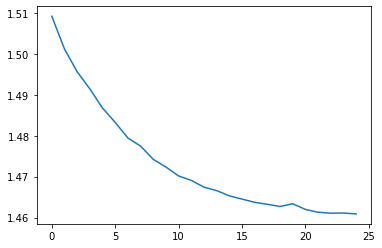

Epoch 1/25
8/8 - 4s - loss: 1.4356 - accuracy: 0.5082 - auc_19: 0.7280 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.2389 - val_loss: 1.2827 - val_accuracy: 0.6311 - val_auc_19: 0.7987 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1935 - 4s/epoch - 520ms/step
Epoch 2/25
8/8 - 0s - loss: 1.4698 - accuracy: 0.6352 - auc_19: 0.8033 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.1952 - val_loss: 1.2409 - val_accuracy: 0.6311 - val_auc_19: 0.7941 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1935 - 389ms/epoch - 49ms/step
Epoch 3/25
8/8 - 0s - loss: 1.4612 - accuracy: 0.6352 - auc_19: 0.8106 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.1952 - val_loss: 1.2505 - val_accuracy: 0.6311 - val_auc_19: 0.7962 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1935 - 434ms/epoch - 54ms/step
Epoch 4/25
8/8 - 0s - loss: 1.4582 - accuracy: 0.6352 - auc_19: 0.

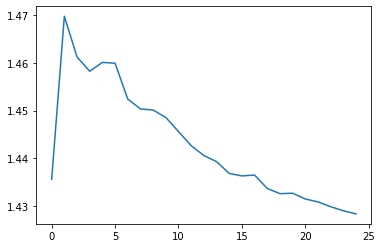

Epoch 1/25
8/8 - 4s - loss: 1.2592 - accuracy: 0.5451 - auc_20: 0.7125 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.2674 - val_loss: 1.2118 - val_accuracy: 0.5902 - val_auc_20: 0.8005 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1856 - 4s/epoch - 473ms/step
Epoch 2/25
8/8 - 0s - loss: 1.2651 - accuracy: 0.6639 - auc_20: 0.8181 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.2094 - val_loss: 1.2210 - val_accuracy: 0.5902 - val_auc_20: 0.8074 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1856 - 393ms/epoch - 49ms/step
Epoch 3/25
8/8 - 0s - loss: 1.2632 - accuracy: 0.6598 - auc_20: 0.8188 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.2166 - val_loss: 1.2278 - val_accuracy: 0.5902 - val_auc_20: 0.8073 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1856 - 391ms/epoch - 49ms/step
Epoch 4/25
8/8 - 0s - loss: 1.2608 - accuracy: 0.6598 - auc_20: 0.

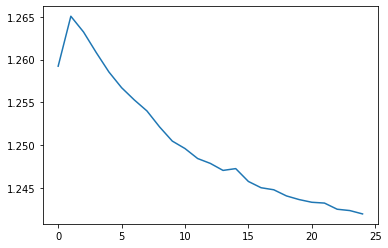

In [28]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [29]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 51.95% 
Balanced Accuracy: 25.66% 
ROC/AUC: 0.73 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.20


### RCNN

In [30]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
8/8 - 2s - loss: 3.2358 - accuracy: 0.2295 - auc_21: 0.5461 - precision_21: 0.2118 - recall_21: 0.1475 - f1_score: 0.1601 - val_loss: 67.5530 - val_accuracy: 0.1393 - val_auc_21: 0.3810 - val_precision_21: 0.1393 - val_recall_21: 0.1393 - val_f1_score: 0.1843 - 2s/epoch - 306ms/step
Epoch 2/25
8/8 - 0s - loss: 1.5660 - accuracy: 0.3443 - auc_21: 0.5939 - precision_21: 0.3547 - recall_21: 0.2500 - f1_score: 0.2760 - val_loss: 8.8197 - val_accuracy: 0.1311 - val_auc_21: 0.3577 - val_precision_21: 0.1311 - val_recall_21: 0.1311 - val_f1_score: 0.1007 - 404ms/epoch - 51ms/step
Epoch 3/25
8/8 - 0s - loss: 1.2501 - accuracy: 0.5287 - auc_21: 0.7932 - precision_21: 0.5669 - recall_21: 0.3648 - f1_score: 0.4518 - val_loss: 11.1121 - val_accuracy: 0.1557 - val_auc_21: 0.3961 - val_precision_21: 0.1557 - val_recall_21: 0.1557 - val_f1_score: 0.1114 - 358ms/epoch - 45ms/step
Epoch 4/25
8/8 - 0s - loss: 1.1440 - accuracy: 0.4918 - auc_21: 0.7759 - precision_21: 0.5353 - recall_21: 0.373

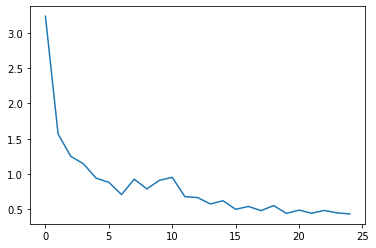

Epoch 1/25
8/8 - 2s - loss: 2.1843 - accuracy: 0.2131 - auc_22: 0.5072 - precision_22: 0.2147 - recall_22: 0.1434 - f1_score: 0.1805 - val_loss: 25.4124 - val_accuracy: 0.1230 - val_auc_22: 0.4184 - val_precision_22: 0.1230 - val_recall_22: 0.1230 - val_f1_score: 0.0581 - 2s/epoch - 239ms/step
Epoch 2/25
8/8 - 0s - loss: 1.3845 - accuracy: 0.3607 - auc_22: 0.6588 - precision_22: 0.3770 - recall_22: 0.2828 - f1_score: 0.3258 - val_loss: 17.6850 - val_accuracy: 0.6475 - val_auc_22: 0.7650 - val_precision_22: 0.6475 - val_recall_22: 0.6475 - val_f1_score: 0.2272 - 359ms/epoch - 45ms/step
Epoch 3/25
8/8 - 0s - loss: 1.1083 - accuracy: 0.5205 - auc_22: 0.7781 - precision_22: 0.5161 - recall_22: 0.3934 - f1_score: 0.3839 - val_loss: 13.0541 - val_accuracy: 0.3279 - val_auc_22: 0.6304 - val_precision_22: 0.3279 - val_recall_22: 0.3279 - val_f1_score: 0.1798 - 361ms/epoch - 45ms/step
Epoch 4/25
8/8 - 0s - loss: 0.9354 - accuracy: 0.4426 - auc_22: 0.7623 - precision_22: 0.4815 - recall_22: 0.37

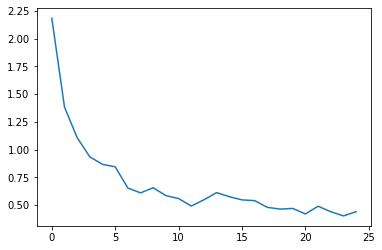

Epoch 1/25
8/8 - 2s - loss: 2.3207 - accuracy: 0.2828 - auc_23: 0.5892 - precision_23: 0.2571 - recall_23: 0.1475 - f1_score: 0.1991 - val_loss: 13.2314 - val_accuracy: 0.0984 - val_auc_23: 0.3460 - val_precision_23: 0.0984 - val_recall_23: 0.0984 - val_f1_score: 0.0919 - 2s/epoch - 240ms/step
Epoch 2/25
8/8 - 0s - loss: 1.2579 - accuracy: 0.4959 - auc_23: 0.7209 - precision_23: 0.4894 - recall_23: 0.2828 - f1_score: 0.3021 - val_loss: 8.9419 - val_accuracy: 0.6230 - val_auc_23: 0.7422 - val_precision_23: 0.6230 - val_recall_23: 0.6230 - val_f1_score: 0.2530 - 360ms/epoch - 45ms/step
Epoch 3/25
8/8 - 0s - loss: 0.9867 - accuracy: 0.4057 - auc_23: 0.7368 - precision_23: 0.4029 - recall_23: 0.2295 - f1_score: 0.3028 - val_loss: 3.5633 - val_accuracy: 0.6230 - val_auc_23: 0.7908 - val_precision_23: 0.6230 - val_recall_23: 0.6230 - val_f1_score: 0.2530 - 399ms/epoch - 50ms/step
Epoch 4/25
8/8 - 0s - loss: 1.0491 - accuracy: 0.4303 - auc_23: 0.7012 - precision_23: 0.4507 - recall_23: 0.2623

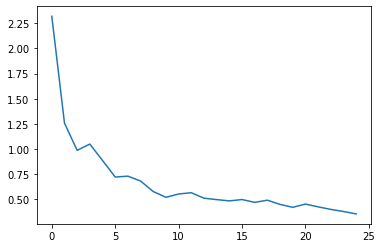

In [31]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [32]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 32.03% 
Balanced Accuracy: 23.84% 
ROC/AUC: 0.64 
Precision: 0.30 
Recall: 0.25 
F1 score: 0.22


### Ensemble

In [33]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [34]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [35]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [36]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.0080)
RCNN Body Model (weight: 0.0002)
CNN + Bidirectional LSTM Face Model (weight: 0.5349)
RCNN Face Model (weight: 0.4568)
Accuracy: 42.42% - ROC/AUC: 0.53 - Precision: 0.30 - Recall: 0.26 - F1 score: 0.23


## Results

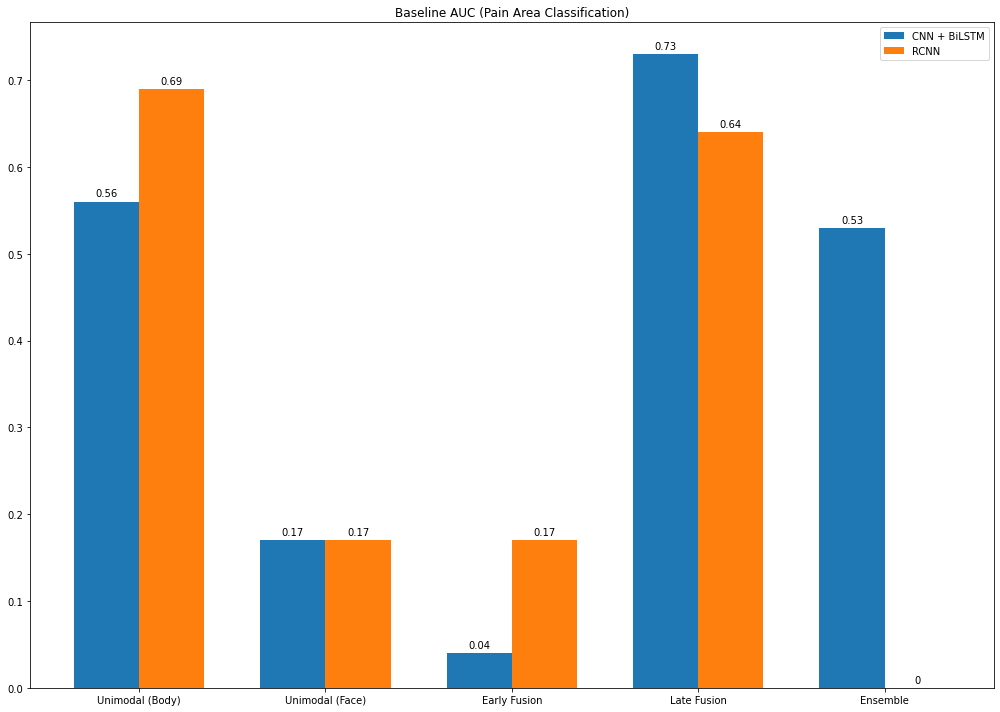

In [37]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']
men_means = cnn_auc
women_means = rnn_auc

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, men_means, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, women_means, width, label='RCNN')

ax.set_title('Baseline AUC (Pain Area Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()